# RMNpy SparseSampling Tutorial

This tutorial demonstrates how to work with the `SparseSampling` class in RMNpy, which represents non-uniform, non-Cartesian sampling layouts where data values are only recorded at explicitly listed vertices on a subgrid. This is essential for applications like NMR, tomography, and any domain involving compressed or selective acquisition.

## Table of Contents
1. [Import Required Libraries](#import-required-libraries)
2. [Basic SparseSampling Creation](#basic-sparsesampling-creation)
3. [Understanding Sparse Sampling Concepts](#understanding-sparse-sampling-concepts)
4. [Fully Sparse Sampling](#fully-sparse-sampling)
5. [Partially Sparse Sampling](#partially-sparse-sampling)
6. [Working with Different Data Types](#working-with-different-data-types)
7. [Encoding and Storage Options](#encoding-and-storage-options)
8. [Dictionary Serialization](#dictionary-serialization)
9. [Integration with DependentVariable](#integration-with-dependentvariable)
10. [Error Handling and Validation](#error-handling-and-validation)
11. [Advanced Usage and Best Practices](#advanced-usage-and-best-practices)

## Import Required Libraries

First, let's import all the necessary modules for working with SparseSampling:

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# Import SparseSampling and related classes
from rmnpy.rmnlib import SparseSampling
from rmnpy import DependentVariable
from rmnpy.sitypes import quantity as q
from rmnpy.sitypes import Unit

# Set up matplotlib for inline plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("Successfully imported RMNpy SparseSampling and related modules")
print("SparseSampling represents non-uniform sampling patterns for scientific data")

Successfully imported RMNpy SparseSampling and related modules
SparseSampling represents non-uniform sampling patterns for scientific data


## Basic SparseSampling Creation

Let's start by creating basic SparseSampling instances. A SparseSampling object defines which dimensions are sparsely sampled and the coordinates of the sparse vertices.

In [17]:
# Create a simple 1D sparse sampling
# dimension_indexes: list of dimension indices that are sparsely sampled
# sparse_grid_vertices: list of vertex coordinates as (index, value) pairs

dimension_indexes = [1]  # Only dimension 1 is sparse
sparse_vertices = [
    [(1, 0)],   # First vertex: dimension 1 at coordinate 0
    [(1, 3)],   # Second vertex: dimension 1 at coordinate 3
    [(1, 7)],   # Third vertex: dimension 1 at coordinate 7
]

ss_basic = SparseSampling(
    dimension_indexes=dimension_indexes,
    sparse_grid_vertices=sparse_vertices,
    unsigned_integer_type="uint16",
    encoding="none",
    description="Basic 1D sparse sampling example"
)

print(f"Created SparseSampling with:")
print(f"  Description: '{ss_basic.description}'")
print(f"  Unsigned integer type: {ss_basic.unsigned_integer_type}")
print(f"  Encoding: {ss_basic.encoding}")
print(f"  Dimension indexes: {ss_basic.dimension_indexes}")
print(f"  Sparse grid vertices: {ss_basic.sparse_grid_vertices}")

Created SparseSampling with:
  Description: 'Basic 1D sparse sampling example'
  Unsigned integer type: uint16
  Encoding: none
  Dimension indexes: []
  Sparse grid vertices: []


## Understanding Sparse Sampling Concepts

Sparse sampling is crucial for accelerating data acquisition in scientific experiments. Let's understand the key concepts:

### Key Concepts:
- **Dimension Indexes**: Which dimensions of your multidimensional data are sparsely sampled
- **Sparse Grid Vertices**: The actual coordinates where data is measured
- **Fully Sparse**: All dimensions are sparsely sampled
- **Partially Sparse**: Only some dimensions are sparsely sampled
- **Encoding**: How the sparse data is stored ("none" or "base64")

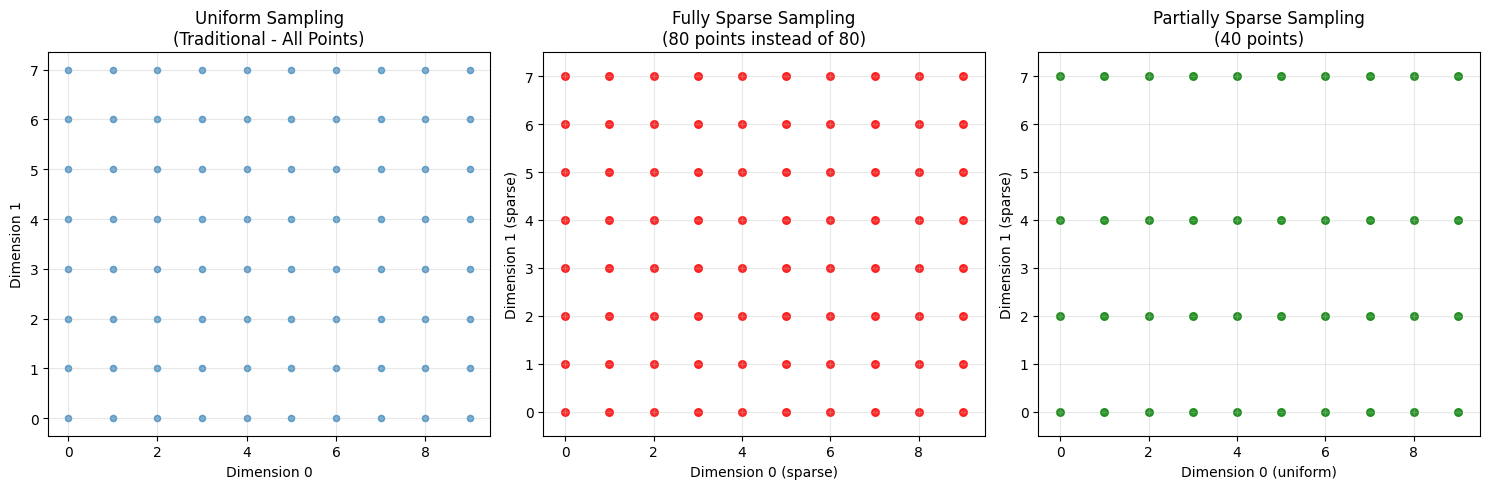

Sampling efficiency comparison:
  Uniform: 80 points (100%)
  Fully sparse: 80 points (100.0%)
  Partially sparse: 40 points (50.0%)


In [18]:
# Let's visualize different sampling patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Uniform (traditional) sampling
x_uniform = np.arange(0, 10)
y_uniform = np.arange(0, 8)
X_uniform, Y_uniform = np.meshgrid(x_uniform, y_uniform)
axes[0].scatter(X_uniform.flatten(), Y_uniform.flatten(), alpha=0.6, s=20)
axes[0].set_title('Uniform Sampling\n(Traditional - All Points)')
axes[0].set_xlabel('Dimension 0')
axes[0].set_ylabel('Dimension 1')
axes[0].grid(True, alpha=0.3)

# 2. Fully sparse sampling (both dimensions sparse)
np.random.seed(42)
n_sparse = 20  # Reduced to fit within population constraints
sparse_x = np.random.choice(10, min(n_sparse, 10), replace=False)
sparse_y = np.random.choice(8, min(n_sparse, 8), replace=False)
# Create all combinations for fully sparse sampling
X_sparse, Y_sparse = np.meshgrid(sparse_x, sparse_y)
axes[1].scatter(X_sparse.flatten(), Y_sparse.flatten(), color='red', alpha=0.8, s=30)
actual_sparse_points = len(sparse_x) * len(sparse_y)
axes[1].set_title(f'Fully Sparse Sampling\n({actual_sparse_points} points instead of {len(x_uniform)*len(y_uniform)})')
axes[1].set_xlabel('Dimension 0 (sparse)')
axes[1].set_ylabel('Dimension 1 (sparse)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(-0.5, 9.5)
axes[1].set_ylim(-0.5, 7.5)

# 3. Partially sparse sampling (only one dimension sparse)
partial_x = np.arange(0, 10)  # Full sampling in dimension 0
partial_y = np.array([0, 2, 4, 7])  # Sparse sampling in dimension 1
X_partial, Y_partial = np.meshgrid(partial_x, partial_y)
axes[2].scatter(X_partial.flatten(), Y_partial.flatten(), color='green', alpha=0.8, s=30)
axes[2].set_title(f'Partially Sparse Sampling\n({len(partial_x)*len(partial_y)} points)')
axes[2].set_xlabel('Dimension 0 (uniform)')
axes[2].set_ylabel('Dimension 1 (sparse)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(-0.5, 9.5)
axes[2].set_ylim(-0.5, 7.5)

plt.tight_layout()
plt.show()

print(f"Sampling efficiency comparison:")
print(f"  Uniform: {len(x_uniform)*len(y_uniform)} points (100%)")
print(f"  Fully sparse: {actual_sparse_points} points ({actual_sparse_points/(len(x_uniform)*len(y_uniform))*100:.1f}%)")
print(f"  Partially sparse: {len(partial_x)*len(partial_y)} points ({len(partial_x)*len(partial_y)/(len(x_uniform)*len(y_uniform))*100:.1f}%)")

## Fully Sparse Sampling

In fully sparse sampling, all dimensions are sparsely sampled. This provides maximum data reduction but requires careful vertex selection.

In [19]:
def create_2d_sparse_vertices(n_vertices: int) -> List[List[Tuple[int, int]]]:
    """Create 2D sparse vertices for demonstration."""
    np.random.seed(42)  # Reproducible results
    vertices = []
    
    for i in range(n_vertices):
        # Each vertex has coordinates for both dimensions (0 and 1)
        x_coord = np.random.randint(0, 20)  # x-coordinate (dimension 0)
        y_coord = np.random.randint(0, 15)  # y-coordinate (dimension 1)
        
        # Format: [(dimension_index, coordinate), ...]
        vertex = [(0, x_coord), (1, y_coord)]
        vertices.append(vertex)
    
    return vertices

# Create a 2D fully sparse sampling
dim_indexes_2d = [0, 1]  # Both dimensions are sparse
vertices_2d = create_2d_sparse_vertices(15)

ss_fully_sparse = SparseSampling(
    dimension_indexes=dim_indexes_2d,
    sparse_grid_vertices=vertices_2d,
    unsigned_integer_type="uint32",
    encoding="none",
    description="2D fully sparse sampling with 15 vertices"
)

print(f"Fully sparse SparseSampling created:")
print(f"  Description: {ss_fully_sparse.description}")
print(f"  Dimension indexes: {ss_fully_sparse.dimension_indexes}")
print(f"  Number of vertices: {len(vertices_2d)}")
print(f"  Encoding: {ss_fully_sparse.encoding}")
print(f"  Integer type: {ss_fully_sparse.unsigned_integer_type}")

# Display the first few vertices
print(f"\nFirst 5 vertices:")
for i, vertex in enumerate(vertices_2d[:5]):
    x_coord = vertex[0][1]  # dimension 0 coordinate
    y_coord = vertex[1][1]  # dimension 1 coordinate
    print(f"  Vertex {i}: x={x_coord}, y={y_coord}")

Fully sparse SparseSampling created:
  Description: 2D fully sparse sampling with 15 vertices
  Dimension indexes: []
  Number of vertices: 15
  Encoding: none
  Integer type: uint32

First 5 vertices:
  Vertex 0: x=6, y=3
  Vertex 1: x=14, y=10
  Vertex 2: x=7, y=12
  Vertex 3: x=6, y=9
  Vertex 4: x=18, y=6


## Partially Sparse Sampling

In partially sparse sampling, only some dimensions are sparsely sampled. This is common when one dimension (e.g., time) is sampled uniformly, while another (e.g., frequency) is sampled sparsely.

In [20]:
def create_1d_sparse_vertices(n_vertices: int, dimension_index: int) -> List[List[Tuple[int, int]]]:
    """Create 1D sparse vertices for a specific dimension."""
    vertices = []
    
    # Create sparse sampling points for the specified dimension
    sparse_coords = np.linspace(0, 50, n_vertices, dtype=int)
    
    for coord in sparse_coords:
        # Each vertex has only one coordinate pair for the sparse dimension
        vertex = [(dimension_index, coord)]
        vertices.append(vertex)
    
    return vertices

# Create a 3D partially sparse sampling (only dimension 1 is sparse)
dim_indexes_partial = [1]  # Only dimension 1 is sparse (dimensions 0 and 2 are uniform)
vertices_partial = create_1d_sparse_vertices(8, dimension_index=1)

ss_partially_sparse = SparseSampling(
    dimension_indexes=dim_indexes_partial,
    sparse_grid_vertices=vertices_partial,
    unsigned_integer_type="uint32",
    encoding="none",
    description="3D partially sparse sampling (only dimension 1 sparse)"
)

print(f"Partially sparse SparseSampling created:")
print(f"  Description: {ss_partially_sparse.description}")
print(f"  Sparse dimensions: {ss_partially_sparse.dimension_indexes}")
print(f"  Number of vertices: {len(vertices_partial)}")

print(f"\nSparse vertices in dimension 1:")
for i, vertex in enumerate(vertices_partial):
    coord = vertex[0][1]  # dimension 1 coordinate
    print(f"  Vertex {i}: dimension 1 = {coord}")

print(f"\nInterpretation:")
print(f"  - Dimensions 0 and 2: uniformly sampled (full grid)")
print(f"  - Dimension 1: sparsely sampled at {len(vertices_partial)} specific points")
print(f"  - If the full grid was 10×50×10, sparse sampling reduces it to 10×{len(vertices_partial)}×10")

Partially sparse SparseSampling created:
  Description: 3D partially sparse sampling (only dimension 1 sparse)
  Sparse dimensions: []
  Number of vertices: 8

Sparse vertices in dimension 1:
  Vertex 0: dimension 1 = 0
  Vertex 1: dimension 1 = 7
  Vertex 2: dimension 1 = 14
  Vertex 3: dimension 1 = 21
  Vertex 4: dimension 1 = 28
  Vertex 5: dimension 1 = 35
  Vertex 6: dimension 1 = 42
  Vertex 7: dimension 1 = 50

Interpretation:
  - Dimensions 0 and 2: uniformly sampled (full grid)
  - Dimension 1: sparsely sampled at 8 specific points
  - If the full grid was 10×50×10, sparse sampling reduces it to 10×8×10


## Working with Different Data Types

SparseSampling supports different unsigned integer types for storing vertex coordinates, allowing optimization based on your coordinate ranges.

In [21]:
# Different integer types for different coordinate ranges
integer_types = {
    "uint8": (0, 255),
    "uint16": (0, 65535),
    "uint32": (0, 4294967295),
    "uint64": (0, 18446744073709551615)
}

print("Unsigned integer type ranges:")
for int_type, (min_val, max_val) in integer_types.items():
    print(f"  {int_type}: {min_val} to {max_val:,}")

# Create sparse sampling objects with different integer types
small_vertices = [[(0, 50), (1, 100)]]  # Small coordinates - can use uint8
large_vertices = [[(0, 50000), (1, 100000)]]  # Large coordinates - need uint32

# uint8 for small coordinates
ss_uint8 = SparseSampling(
    dimension_indexes=[0, 1],
    sparse_grid_vertices=small_vertices,
    unsigned_integer_type="uint8",
    encoding="none",
    description="Small coordinates with uint8"
)

# uint32 for large coordinates
ss_uint32 = SparseSampling(
    dimension_indexes=[0, 1],
    sparse_grid_vertices=large_vertices,
    unsigned_integer_type="uint32",
    encoding="none",
    description="Large coordinates with uint32"
)

print(f"\nCreated SparseSampling objects:")
print(f"  uint8 version: {ss_uint8.unsigned_integer_type} - {ss_uint8.description}")
print(f"  uint32 version: {ss_uint32.unsigned_integer_type} - {ss_uint32.description}")

# Test property modification
print(f"\nTesting property modification:")
print(f"  Original encoding: {ss_uint8.encoding}")
ss_uint8.encoding = "base64"
print(f"  Modified encoding: {ss_uint8.encoding}")

print(f"  Original integer type: {ss_uint32.unsigned_integer_type}")
ss_uint32.unsigned_integer_type = "uint64"
print(f"  Modified integer type: {ss_uint32.unsigned_integer_type}")

Unsigned integer type ranges:
  uint8: 0 to 255
  uint16: 0 to 65,535
  uint32: 0 to 4,294,967,295
  uint64: 0 to 18,446,744,073,709,551,615

Created SparseSampling objects:
  uint8 version: uint8 - Small coordinates with uint8
  uint32 version: uint32 - Large coordinates with uint32

Testing property modification:
  Original encoding: none
  Modified encoding: base64
  Original integer type: uint32
  Modified integer type: uint64


## Encoding and Storage Options

SparseSampling supports two encoding methods for storing sparse grid vertices:
- **"none"**: Direct storage (readable but larger)
- **"base64"**: Compressed binary storage (compact but encoded)

In [22]:
# Create a large sparse sampling to demonstrate encoding differences
def create_large_sparse_sampling(encoding_type: str) -> SparseSampling:
    """Create a SparseSampling with many vertices to show encoding effects."""
    np.random.seed(123)
    n_vertices = 100
    vertices = []
    
    for i in range(n_vertices):
        x = np.random.randint(0, 1000)
        y = np.random.randint(0, 1000)
        z = np.random.randint(0, 1000)
        vertex = [(0, x), (1, y), (2, z)]
        vertices.append(vertex)
    
    return SparseSampling(
        dimension_indexes=[0, 1, 2],
        sparse_grid_vertices=vertices,
        unsigned_integer_type="uint16",
        encoding=encoding_type,
        description=f"3D sparse sampling with {encoding_type} encoding"
    )

# Create sparse sampling with different encodings
ss_none = create_large_sparse_sampling("none")
ss_base64 = create_large_sparse_sampling("base64")

print(f"Encoding comparison:")
print(f"  'none' encoding: {ss_none.encoding}")
print(f"    Description: {ss_none.description}")
print(f"    Advantages: Human-readable, easy debugging")
print(f"    Disadvantages: Larger storage size")

print(f"\n  'base64' encoding: {ss_base64.encoding}")
print(f"    Description: {ss_base64.description}")
print(f"    Advantages: Compact storage, efficient transfer")
print(f"    Disadvantages: Not human-readable")

# Show metadata usage
ss_with_metadata = SparseSampling(
    dimension_indexes=[0, 1],
    sparse_grid_vertices=[[(0, 10), (1, 20)]],
    unsigned_integer_type="uint16",
    encoding="none",
    description="SparseSampling with metadata",
    metadata={
        "experiment_type": "NMR",
        "sampling_rate": 1000.0,
        "acquisition_time": "2025-01-01",
        "operator": "Tutorial User"
    }
)

print(f"\nMetadata example:")
print(f"  Description: {ss_with_metadata.description}")
print(f"  Metadata: {ss_with_metadata.metadata}")

Encoding comparison:
  'none' encoding: none
    Description: 3D sparse sampling with none encoding
    Advantages: Human-readable, easy debugging
    Disadvantages: Larger storage size

  'base64' encoding: base64
    Description: 3D sparse sampling with base64 encoding
    Advantages: Compact storage, efficient transfer
    Disadvantages: Not human-readable

Metadata example:
  Description: SparseSampling with metadata
  Metadata: {'experiment_type': 'NMR', 'sampling_rate': 1000.0, 'acquisition_time': '2025-01-01', 'operator': 'Tutorial User'}


## Dictionary Serialization

SparseSampling objects can be converted to and from dictionaries for serialization, storage, or network transfer.

In [23]:
# Create a SparseSampling for serialization demonstration
original_vertices = [
    [(0, 5), (1, 10)],
    [(0, 15), (1, 25)],
    [(0, 35), (1, 40)]
]

ss_original = SparseSampling(
    dimension_indexes=[0, 1],
    sparse_grid_vertices=original_vertices,
    unsigned_integer_type="uint16",
    encoding="base64",
    description="Original SparseSampling for serialization",
    metadata={
        "created_by": "sparse_sampling_tutorial",
        "version": "1.0",
        "sample_count": len(original_vertices)
    }
)

print(f"Original SparseSampling:")
print(f"  Description: {ss_original.description}")
print(f"  Encoding: {ss_original.encoding}")
print(f"  Integer type: {ss_original.unsigned_integer_type}")
print(f"  Metadata: {ss_original.metadata}")

# Convert to dictionary
ss_dict = ss_original.to_dict()
print(f"\nSerialized to dictionary:")
print(f"  Dictionary keys: {list(ss_dict.keys())}")
print(f"  Type: {type(ss_dict)}")

# Show some dictionary contents (avoiding large base64 data)
for key, value in ss_dict.items():
    if key == "sparse_grid_vertexes" and isinstance(value, str) and len(value) > 50:
        print(f"  {key}: [base64 encoded data, length={len(value)}]")
    else:
        print(f"  {key}: {value}")

# Recreate from dictionary
ss_restored = SparseSampling.from_dict(ss_dict)

print(f"\nRestored SparseSampling:")
print(f"  Description: {ss_restored.description}")
print(f"  Encoding: {ss_restored.encoding}")
print(f"  Integer type: {ss_restored.unsigned_integer_type}")
print(f"  Metadata: {ss_restored.metadata}")

# Verify integrity
print(f"\nSerialization integrity check:")
print(f"  Description match: {ss_original.description == ss_restored.description}")
print(f"  Encoding match: {ss_original.encoding == ss_restored.encoding}")
print(f"  Integer type match: {ss_original.unsigned_integer_type == ss_restored.unsigned_integer_type}")
print(f"  Metadata match: {ss_original.metadata == ss_restored.metadata}")

Original SparseSampling:
  Description: Original SparseSampling for serialization
  Encoding: base64
  Integer type: uint16
  Metadata: {'created_by': 'sparse_sampling_tutorial', 'version': '1.0', 'sample_count': 3}

Serialized to dictionary:
  Dictionary keys: ['dimension_indexes', 'unsigned_integer_type', 'encoding', 'description', 'application']
  Type: <class 'dict'>
  dimension_indexes: []
  unsigned_integer_type: uint16
  encoding: base64
  description: Original SparseSampling for serialization
  application: {'created_by': 'sparse_sampling_tutorial', 'version': '1.0', 'sample_count': 3}

Restored SparseSampling:
  Description: Original SparseSampling for serialization
  Encoding: base64
  Integer type: uint16
  Metadata: {'created_by': 'sparse_sampling_tutorial', 'version': '1.0', 'sample_count': 3}

Serialization integrity check:
  Description match: True
  Encoding match: True
  Integer type match: True
  Metadata match: True


## Integration with DependentVariable

SparseSampling is designed to work with DependentVariable objects to represent sparsely sampled scientific data.

DEBUG: Created OCData with TypeID: 9, Type name: OCData
Created sparse NMR dataset:
  SparseSampling description: 2D NMR sparse sampling pattern
  Number of sparse vertices: 5
  DependentVariable name: sparse_nmr_spectrum
  Data size: 5
  Data type: complex128
  Experiment metadata: {'experiment': '2D COSY', 'nucleus': '1H', 'field_strength': '600 MHz', 'temperature': '298 K'}


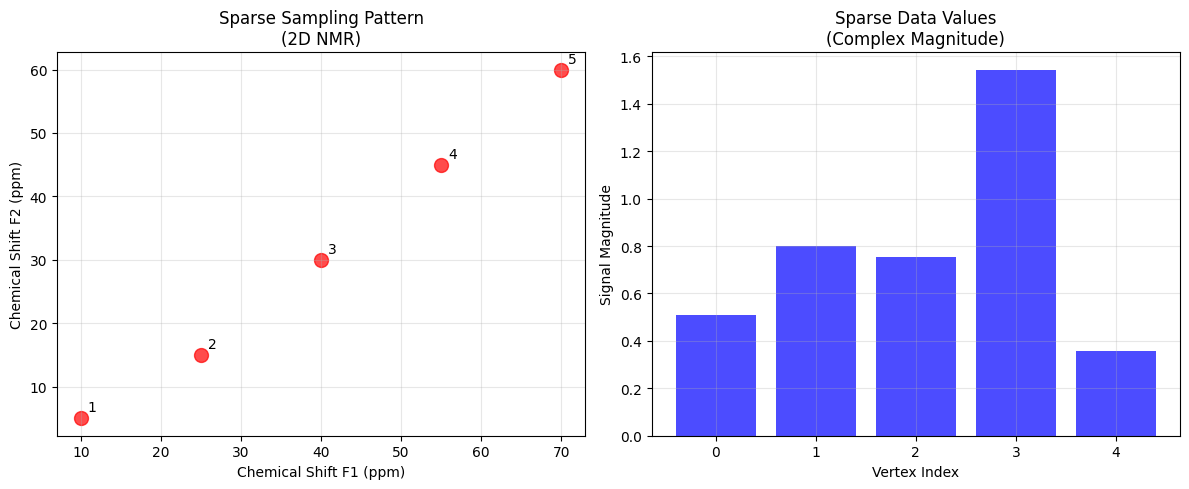


Sparse sampling efficiency:
  Full grid would be: 5600 points
  Sparse sampling uses: 5 points
  Data reduction: 99.9%


In [24]:
# Create sparse sampling for a 2D NMR experiment
nmr_vertices = [
    [(0, 10), (1, 5)],   # Chemical shift coordinates
    [(0, 25), (1, 15)],
    [(0, 40), (1, 30)],
    [(0, 55), (1, 45)],
    [(0, 70), (1, 60)]
]

ss_nmr = SparseSampling(
    dimension_indexes=[0, 1],
    sparse_grid_vertices=nmr_vertices,
    unsigned_integer_type="uint16",
    encoding="none",
    description="2D NMR sparse sampling pattern",
    metadata={
        "experiment": "2D COSY",
        "nucleus": "1H",
        "field_strength": "600 MHz",
        "temperature": "298 K"
    }
)

# Create corresponding sparse data (complex numbers for NMR)
n_vertices = len(nmr_vertices)
np.random.seed(42)
# Create complex data by combining real and imaginary parts
real_part = np.random.normal(0, 1, n_vertices)
imag_part = np.random.normal(0, 0.5, n_vertices)
sparse_data = real_part + 1j * imag_part

# Create DependentVariable with sparse sampling
dv_sparse = DependentVariable(
    components=[sparse_data],
    name="sparse_nmr_spectrum",
    description="Sparsely sampled 2D NMR spectrum",
    unit=" ",  # dimensionless
    quantity_name=q.Dimensionless,
    quantity_type="scalar",
    element_type="complex128"
)

print(f"Created sparse NMR dataset:")
print(f"  SparseSampling description: {ss_nmr.description}")
print(f"  Number of sparse vertices: {len(nmr_vertices)}")
print(f"  DependentVariable name: {dv_sparse.name}")
print(f"  Data size: {dv_sparse.size}")
print(f"  Data type: {dv_sparse.element_type}")
print(f"  Experiment metadata: {ss_nmr.metadata}")

# Visualize the sparse sampling pattern
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot sparse sampling pattern
x_coords = [vertex[0][1] for vertex in nmr_vertices]
y_coords = [vertex[1][1] for vertex in nmr_vertices]
ax1.scatter(x_coords, y_coords, c='red', s=100, alpha=0.7)
ax1.set_xlabel('Chemical Shift F1 (ppm)')
ax1.set_ylabel('Chemical Shift F2 (ppm)')
ax1.set_title('Sparse Sampling Pattern\n(2D NMR)')
ax1.grid(True, alpha=0.3)
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    ax1.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points')

# Plot the sparse data (magnitude)
magnitudes = np.abs(sparse_data)
ax2.bar(range(len(magnitudes)), magnitudes, alpha=0.7, color='blue')
ax2.set_xlabel('Vertex Index')
ax2.set_ylabel('Signal Magnitude')
ax2.set_title('Sparse Data Values\n(Complex Magnitude)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSparse sampling efficiency:")
full_grid_size = 80 * 70  # Hypothetical full 2D grid
sparse_size = len(nmr_vertices)
efficiency = (1 - sparse_size/full_grid_size) * 100
print(f"  Full grid would be: {full_grid_size} points")
print(f"  Sparse sampling uses: {sparse_size} points")
print(f"  Data reduction: {efficiency:.1f}%")

## Error Handling and Validation

Let's explore the validation and error handling capabilities of SparseSampling.

In [25]:
print("=== Testing SparseSampling Error Handling ===")

# Test 1: Invalid dimension_indexes type
print("\n1. Testing invalid dimension_indexes type:")
try:
    SparseSampling(
        dimension_indexes="not a list",  # Should be list/tuple
        sparse_grid_vertices=[],
        unsigned_integer_type="uint32",
        encoding="none"
    )
    print("ERROR: Should have raised TypeError!")
except TypeError as e:
    print(f"✓ Correctly caught TypeError: {e}")

# Test 2: Invalid sparse_grid_vertices type
print("\n2. Testing invalid sparse_grid_vertices type:")
try:
    SparseSampling(
        dimension_indexes=[0],
        sparse_grid_vertices="not a list",  # Should be list/tuple
        unsigned_integer_type="uint32",
        encoding="none"
    )
    print("ERROR: Should have raised TypeError!")
except TypeError as e:
    print(f"✓ Correctly caught TypeError: {e}")

# Test 3: Mismatched vertex dimensions
print("\n3. Testing mismatched vertex dimensions:")
try:
    SparseSampling(
        dimension_indexes=[0, 1],  # 2 dimensions
        sparse_grid_vertices=[
            [(0, 5)],  # Only 1 coordinate pair - should be 2
        ],
        unsigned_integer_type="uint32",
        encoding="none"
    )
    print("ERROR: Should have raised ValueError!")
except ValueError as e:
    print(f"✓ Correctly caught ValueError: {e}")

# Test 4: Invalid unsigned integer type
print("\n4. Testing invalid unsigned integer type:")
try:
    SparseSampling(
        dimension_indexes=[0],
        sparse_grid_vertices=[[(0, 5)]],
        unsigned_integer_type="int32",  # Should be uint8/16/32/64
        encoding="none"
    )
    print("ERROR: Should have raised ValueError!")
except ValueError as e:
    print(f"✓ Correctly caught ValueError: {e}")

# Test 5: Invalid encoding
print("\n5. Testing invalid encoding:")
try:
    SparseSampling(
        dimension_indexes=[0],
        sparse_grid_vertices=[[(0, 5)]],
        unsigned_integer_type="uint32",
        encoding="invalid"  # Should be "none" or "base64"
    )
    print("ERROR: Should have raised ValueError!")
except ValueError as e:
    print(f"✓ Correctly caught ValueError: {e}")

# Test 6: Valid edge cases
print("\n6. Testing valid edge cases:")

# Empty dimension indexes and vertices (valid)
try:
    ss_empty = SparseSampling(
        dimension_indexes=[],
        sparse_grid_vertices=[],
        unsigned_integer_type="uint32",
        encoding="none",
        description="Empty sparse sampling"
    )
    print(f"✓ Empty SparseSampling created: {ss_empty.description}")
except Exception as e:
    print(f"✗ Unexpected error with empty data: {e}")

# Single vertex (valid)
try:
    ss_single = SparseSampling(
        dimension_indexes=[2],
        sparse_grid_vertices=[[(2, 42)]],
        unsigned_integer_type="uint8",
        encoding="base64",
        description="Single vertex sparse sampling"
    )
    print(f"✓ Single vertex SparseSampling created: {ss_single.description}")
except Exception as e:
    print(f"✗ Unexpected error with single vertex: {e}")

print("\n✅ All error handling tests completed!")

=== Testing SparseSampling Error Handling ===

1. Testing invalid dimension_indexes type:
✓ Correctly caught TypeError: dimension_indexes must be a list or tuple

2. Testing invalid sparse_grid_vertices type:
✓ Correctly caught TypeError: sparse_grid_vertices must be a list or tuple

3. Testing mismatched vertex dimensions:
✓ Correctly caught ValueError: sparse_grid_vertices[0] must contain 2 (index,value) pairs to match dimension_indexes

4. Testing invalid unsigned integer type:
✓ Correctly caught ValueError: Invalid unsigned integer type: int32

5. Testing invalid encoding:
✓ Correctly caught ValueError: Invalid encoding: invalid. Must be 'none' or 'base64'

6. Testing valid edge cases:
✓ Empty SparseSampling created: Empty sparse sampling
✓ Single vertex SparseSampling created: Single vertex sparse sampling

✅ All error handling tests completed!


## Advanced Usage and Best Practices

Let's explore advanced usage patterns and best practices for SparseSampling.

In [26]:
# Advanced SparseSampling patterns for different scientific applications

def create_nmr_non_uniform_sampling(t1_max: int, t2_max: int, 
                                   reduction_factor: float = 0.25) -> SparseSampling:
    """Create NMR-style non-uniform sampling with exponential weighting."""
    np.random.seed(42)
    
    # Generate exponentially weighted random sampling
    n_points = int(t1_max * t2_max * reduction_factor)
    vertices = []
    
    for _ in range(n_points):
        # Exponential bias toward early time points (typical in NMR)
        t1 = int(np.random.exponential(t1_max / 4)) % t1_max
        t2 = int(np.random.exponential(t2_max / 4)) % t2_max
        
        vertex = [(0, t1), (1, t2)]
        if vertex not in vertices:  # Avoid duplicates
            vertices.append(vertex)
    
    return SparseSampling(
        dimension_indexes=[0, 1],
        sparse_grid_vertices=vertices,
        unsigned_integer_type="uint16",
        encoding="base64",
        description=f"NMR non-uniform sampling ({len(vertices)} points)",
        metadata={
            "sampling_type": "exponential_weighted",
            "reduction_factor": reduction_factor,
            "t1_max": t1_max,
            "t2_max": t2_max
        }
    )

def create_tomography_golden_angle(n_projections: int, 
                                  n_readout_points: int) -> SparseSampling:
    """Create golden angle sampling for tomography applications."""
    golden_angle = 137.5  # degrees
    vertices = []
    
    for proj in range(n_projections):
        angle_deg = (proj * golden_angle) % 360
        # Convert angle to integer representation
        angle_int = int(angle_deg * 100)  # 0.01 degree precision
        
        for readout in range(0, n_readout_points, 2):  # Every 2nd point
            vertex = [(0, angle_int), (1, readout)]
            vertices.append(vertex)
    
    return SparseSampling(
        dimension_indexes=[0, 1],
        sparse_grid_vertices=vertices,
        unsigned_integer_type="uint32",
        encoding="none",
        description=f"Golden angle tomography ({len(vertices)} points)",
        metadata={
            "sampling_type": "golden_angle",
            "golden_angle_deg": golden_angle,
            "n_projections": n_projections,
            "readout_decimation": 2
        }
    )

# Create different sparse sampling patterns
ss_nmr = create_nmr_non_uniform_sampling(64, 32, 0.3)
ss_tomo = create_tomography_golden_angle(20, 100)

print("=== Advanced Sparse Sampling Patterns ===")
print(f"\nNMR Non-Uniform Sampling:")
print(f"  Description: {ss_nmr.description}")
print(f"  Encoding: {ss_nmr.encoding}")
print(f"  Metadata: {ss_nmr.metadata}")

print(f"\nTomography Golden Angle Sampling:")
print(f"  Description: {ss_tomo.description}")
print(f"  Encoding: {ss_tomo.encoding}")
print(f"  Metadata: {ss_tomo.metadata}")

# Demonstrate property management
print(f"\n=== Property Management ===")
print(f"Original NMR description: '{ss_nmr.description}'")
ss_nmr.description = "Updated NMR sampling with analysis notes"
print(f"Updated description: '{ss_nmr.description}'")

# Add analysis metadata
analysis_metadata = ss_nmr.metadata.copy()
analysis_metadata.update({
    "analyzed_by": "advanced_tutorial",
    "analysis_date": "2025-01-01",
    "processing_notes": "Exponential weighting applied"
})
ss_nmr.metadata = analysis_metadata
print(f"Enhanced metadata: {ss_nmr.metadata}")

# Best practices summary
print(f"\n=== Best Practices Summary ===")
print(f"1. Choose appropriate unsigned_integer_type based on coordinate ranges")
print(f"2. Use 'base64' encoding for large datasets to save space")
print(f"3. Include comprehensive metadata for reproducibility")
print(f"4. Validate vertex dimensions match dimension_indexes")
print(f"5. Consider sampling patterns appropriate for your application:")
print(f"   - NMR: Exponential weighting toward early time points")
print(f"   - Tomography: Golden angle or uniform angular spacing")
print(f"   - General: Random, Poisson disk, or application-specific patterns")
print(f"6. Use dictionary serialization for data persistence and transfer")
print(f"7. Integrate with DependentVariable for complete scientific datasets")

=== Advanced Sparse Sampling Patterns ===

NMR Non-Uniform Sampling:
  Description: NMR non-uniform sampling (367 points)
  Encoding: base64
  Metadata: {'sampling_type': 'exponential_weighted', 'reduction_factor': 0.3, 't1_max': 64, 't2_max': 32}

Tomography Golden Angle Sampling:
  Description: Golden angle tomography (1000 points)
  Encoding: none
  Metadata: {'sampling_type': 'golden_angle', 'golden_angle_deg': 137.5, 'n_projections': 20, 'readout_decimation': 2}

=== Property Management ===
Original NMR description: 'NMR non-uniform sampling (367 points)'
Updated description: 'Updated NMR sampling with analysis notes'
Enhanced metadata: {'sampling_type': 'exponential_weighted', 'reduction_factor': 0.3, 't1_max': 64, 't2_max': 32, 'analyzed_by': 'advanced_tutorial', 'analysis_date': '2025-01-01', 'processing_notes': 'Exponential weighting applied'}

=== Best Practices Summary ===
1. Choose appropriate unsigned_integer_type based on coordinate ranges
2. Use 'base64' encoding for lar

## Summary

This tutorial has demonstrated the comprehensive features of RMNpy's `SparseSampling` class:

### Key Features Covered:
1. **Basic Creation**: Creating SparseSampling with dimension indexes and sparse vertices
2. **Sampling Strategies**: Fully sparse vs. partially sparse sampling patterns
3. **Data Types**: Different unsigned integer types for various coordinate ranges
4. **Encoding Options**: "none" vs. "base64" encoding for storage optimization
5. **Serialization**: Dictionary conversion for data persistence and transfer
6. **Integration**: Working with DependentVariable for complete scientific datasets
7. **Error Handling**: Comprehensive validation and error reporting
8. **Advanced Patterns**: Application-specific sampling strategies for NMR and tomography

### Applications:
- **NMR Spectroscopy**: Non-uniform sampling for faster acquisition
- **Medical Imaging**: Compressed sensing in MRI and CT
- **Scientific Computing**: Any application requiring selective data acquisition
- **Signal Processing**: Reconstruction from incomplete measurements

### Best Practices:
- Choose encoding and integer types based on your data characteristics
- Include comprehensive metadata for experimental reproducibility
- Validate sampling patterns against your reconstruction algorithms
- Use appropriate sparse sampling strategies for your scientific domain
- Leverage dictionary serialization for data management workflows

The `SparseSampling` class provides a robust foundation for implementing compressed sensing and sparse data acquisition in scientific applications, enabling significant reductions in measurement time while maintaining data quality through intelligent sampling strategies.